# Lecture 2: Model construction

## Lecture overview

1. [Constructing a model](#section1)
2. [Example: Hardy-Weinberg equilibrium](#section2)

<span id='section1'></span>
## 1. Constructing a model
<hr>

Although many problems require specific formulations and assumptions, there are a few general principles to constructing a model.

### i. Formulate the question

- What do you want to know?
- Describe the model in the form of a question.
- Simplify, Simplify!
- Start with the simplest, biologically reasonable description of the problem.

For example, we might ask: how does immigration affect population size?


### ii. Determine the basic ingredients

- Define the **variables** in the model.
- Describe any constraints on the variables.
- Describe any interactions between variables.
- Decide whether you will treat time as continuous or discrete.
- Choose a time scale (i.e., decide what a time step equals in discrete time and specify whether rates will be measured per second, minute, day, year, generation, etc.).
- Define the **parameters** in the model.
- Describe any constraints on the parameters.

In our example, there is a single variable, $n(t)$, denoting population size at time $t$. This must be non-negative, $n(t)\geq0$, to be biologically valid. 

We'll look at both continuous and discrete time, with an arbitrary time scale (if we wanted to plug in some numerical parameter values we'd have to specify this, but here we won't).

In continuous time our parameters will be immigration rate ($m$), per capita birth rate ($b$), and per capita death rate ($d$). These must all be non-negative under our interpretation. The units of $m$ are individuals/time while the units of $b$ and $d$ are simply 1/time (e.g., for birth we have the number of individuals produced per individual per time, so that individuals cancels out and we are left with 1/time).

In discrete time the parameters will be the average number of immigrants per time step ($M$), the average number of offspring per individual per time step ($B$), and the fraction of individuals that die each time step ($D$). These must all be non-negative and $D$ must also be less than or equal to 1 as it is a fraction. 

### iii. Qualitatively describe the biological system

For continuous-time models, draw a **flow diagram** to describe changes to the variables over time. For our example we could draw the following:
    
<center>
```mermaid
graph LR;
    A((n)) --birth--> A;
    B[ ] --migration--> A;
    A --death--> C[ ];
    style B height:0px;
    style C height:0px;
```   
</center>

For discrete-time models, draw a **life-cycle diagram** with all the events that occur each time unit. For our example, if we assume migration, then birth, then death each time step, we could draw the following:

<center>
```mermaid
graph LR;
    A((n)) --migration--> B((n'));
    B --birth--> C((n''));
    C --death--> A;
```   
</center>

For discrete time models with multiple variables and events, construct a table listing the outcome of every event. We'll see an example of this below.

### iv. Quantitatively describe the biological system

Using the diagrams and tables as a guide, write down the equations. Perform checks. Are the constraints on the variables still met as time passes? Make sure that the units of the right-hand side equal those on the left-hand side.

For continuous-time models, add rates for arrows coming in to the flow diagram and subtract rates for arrows coming out of the flow diagram. 

For example, in the model shown above the rate of change in the number of individuals, $\frac{\mathrm{d} n}{\mathrm{d} t}$, is

$$
\begin{aligned}
\frac{\mathrm{d} n}{\mathrm{d} t} &= m + b n(t) - d n(t)\\
&= m + (b - d) n(t)
\end{aligned}
$$

This is a **differential equation**.

In discrete time, you must take into account the order of events when constructing equations. To build an equation for the population size in the next generation, $n(t+1)$, based on the life-cycle diagram above, first construct an equation for each event 

$$n' = n(t) + m$$

$$n'' = n' + bn'$$

$$n(t+1) = n'' - dn''$$

Next, substitute $n''$ and then $n'$ into the equation for $n(t+1)$ to write $n(t+1)$ in terms of $n(t)$

$$
\begin{aligned}
n(t+1) &= n'' − dn'' \\
&= (n' + bn′) − d(n' + bn′) \\
&= n'(1 + b − d − db) \\
&= (n(t) + m)(1 + b − d − db) \\
\end{aligned}
$$

We now have a **recursion equation** that correctly takes into account the order of the life cycle (migration, birth, death) and the point at which the census is taken (immediately after death).

### v. Analyze the equations

- Start by using the equations to simulate and graph the changes to the system over time. 
- Choose and perform appropriate analyses.
- Make sure that the analyses can address the problem.

We'll save the mathematical analyses for later in the course, but we can use the above equations to simulate the model.

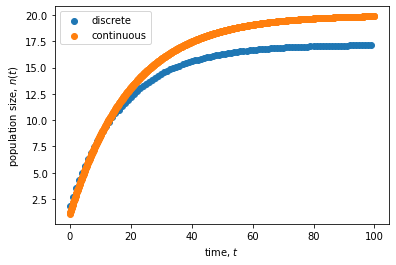

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# define
def discrete_model(nt, b, d, m):
    '''recursion equation giving population size in next time step as a function
    of the population size at this time, nt, and the birth, death, and immigration rates, 
    b, d, and m.'''
    return (nt + m) * (1 + b - d - b*d) #the recursion equation we derived above

def continuous_model(nt, b, d, m, dt):
    '''approximate differential equation giving population size in next time step as a function
    of the population size at this time, nt, and the birth, death, and immigration rates, 
    b, d, and m. The dt is the size of the time step: as this approaches 0 we get the differential equation.'''
    return nt + (m + (b - d)*nt)*dt #the differential equation we derived above

# simulate
nd, nc = [], [] #empty lists to store data
ntd, ntc = 1, 1 #initial popn size
b, d, m, T, dt = 0.05, 0.1, 1, 100, 0.1 #parameter values
for t in np.arange(0,T,dt):
    if t%1==0:
        ntd = discrete_model(ntd, b, d, m) #get the next population size from the recursion equation
        nd.append(ntd) #and append it to the list
    ntc = continuous_model(ntc, b, d, m, dt) #get the next population size from the differential equation
    nc.append(ntc) #and append it to the list

# plot
fig, ax = plt.subplots()
ax.scatter(np.arange(0, T), nd, label='discrete') #plot population size at each time
ax.scatter(np.arange(0, T, dt), nc, label='continuous') #plot population size at each time
ax.set_xlabel('time, $t$')
ax.set_ylabel('population size, $n(t)$')
plt.legend()
plt.show()

### vi. Checks and balances

- Check the results against data or any known special cases.
- Determine how general the results are.
- Consider alternatives to the simplest model.
- Extend or simplify the model, as appropriate, and repeat steps 2-5.

If $b>d$ the population grows without bound (try this in the code above). But competition should prevent unbounded population growth. We could therefore extend the model to include competition. We'll see one way to do this in the next lecture.

### vii. Relate the results back to the question

- Do the results answer the biological question?
- Are the results counter-intuitive? Why?
- Interpret the results verbally, and describe conceptually any new insights into the biological process.
- Describe potential experiments.

Immigration appears to increase the population size (try setting $m=0$ for comparison in the code above), though we'd need to do the mathematical analysis to be more confident in this statement. 

There is some counter-intuitiveness in the discrete model: try creating the recursion equation for a different order of events in the lifecycle. The recursion equation depends on the order and will therefore lead to different dynamics.

Potential experiments incude manipulating immigration in lab populations (e.g., bacteria) or comparing population sizes on islands that are different distances from the mainland.

<span id='section2'></span>
## 2. Example: Hardy-Weinberg equilibrium
<hr>

To demonstrate how to use a **table of events** let's revisit what should be a familiar evolutionary concept: Hardy-Weinberg equilibrium.

#### i. Formulate the question
- **What do you want to know**
    - How do genotype frequencies change due to random mating and segregation alone?
- **Boil the question down**
    - In a population with two variant "alleles" of a gene (A and a), how will the frequencies of the AA, Aa, and aa diploid genotypes change over time?
- **Simple, biologically reasonable description**
    - We assume all individuals have equal fitness and that individuals reproduce and then die (non-overlapping generations). We also assume that individuals produce haploid gametes via meiosis (segregation) to form a gamete pool. Gametes within the gamete pool unite at random to produce the next generation of diploid individuals.
    
#### ii. Determine the basic ingredients

- **Variables**
    - $x$ = frequency of AA individuals
    - $y$ = frequency of Aa individuals
    - $z$ = frequency of aa individuals
    - From these we can extract the allele frequencies:
        - the frequency of A is $p = x + y/2$ (ie, all of the alleles in genotype AA ($x$) are A but only 1/2 of the alleles in genotype Aa ($y$) are A)
        - the frequency of a is $q = 1 - p = y/2 + z$
- **Constraints on these variables**
    - $x$, $y$, $z$ are $≥0$ and $≤1$
    - $x+y+z=1$
- **How we'll treat time**
    - We will follow the genotype frequencies from one generation to the next, using a discrete-time model
- **Parameters**
    - there are no parameters in this model (which is a little bit unusual!)

#### iii. Qualitatively describe the biological system

Diploid adults undergo meiosis, creating haploid gametes, and die. Gametes unite at random in the gamete pool to produce diploid offspring, which form the adults in next generation. Below we draw the life-cycle diagram.

<center>
```mermaid
    graph LR;
    A((x,y,z)) --meiosis--> B((p'));
    B --union--> A;
```
</center>

Since there are no diploid genotypes in the gamete pooled formed after meiosis, there we track the frequency of the A allele, $p'$.

#### iv. Quantiatively describe the biological system
                          
If all individuals create the same number of gametes and each individual produces an equal number of gametes with each allele then meiosis/segregation does not change allele frequencies, $p'=p(t)=x(t)+y(t)/2$.

To calculate the frequency of each genoytpe in the next generation, via random union of gametes, we use a table of events. The "Union" column indicates the pair of gametes that are meeting each other, the "Frequency" column indicates the proportion of gamete pairs in the population with this particular union, and the remaining columns indicate which diploid genotype is created by the union.

| Union | Frequency | AA | Aa | aa |
| ----- | --------- | -- | -- | -- |
| A x A | $p'^2$ | 1 | 0 | 0 |
| A x a | $p'q'$ | 0 | 1 | 0 |
| a x A | $q'p'$ | 0 | 1 | 0 |
| a x a | $q'^2$ | 0 | 0 | 1 |
| | | <span style='color: red'>$p'^2$</span> | <span style='color: red'>$2p'q'$</span> | <span style='color: red'> $q'^2$ </span> |

The genotype frequencies denoted in <span style='color: red'>red</span> are known as the **Hardy-Weinberg frequencies**. They relate the genotype frequencies with the allele frequency. This table shows that populations not at "Hardy-Weinberg equilibrium" reach Hardy-Weinberg equilibrium after only one generation of random mating.

We now have the frequency of genotypes in the next generation in terms of the allele frequencies in the previous generation,

$$x(t+1) = p'^2 = p(t)^2$$

$$y(t+1) = 2p'q' = 2p(t)q(t)$$

$$z(t+1) = q'^2 = q(t)^2$$

To understand how the genotype frequencies at Hardy-Weinberg vary with allele frequency, we can plot them.

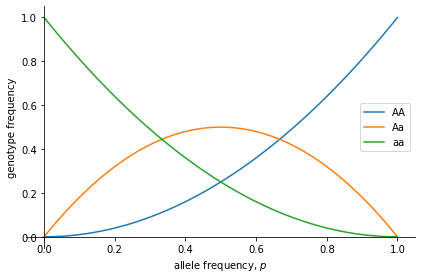

In [1]:
from sympy import *
var('p')
x = p**2 #frequency of AA at Hardy-Weinberg as a function of the frequency of allele A
y = 2*p*(1-p) #freq of Aa
z = (1-p)**2 #freq of aa
p = plot(x, y, z, #functions that we are plotting
     (p,0,1), #plot as a function of allele frequency from 0 to 1
     xlabel="allele frequency, $p$", 
     ylabel="genotype frequency",
     legend=True, show=False
    )
p[0].label='AA' #give legend genotype labels
p[1].label='Aa'
p[2].label='aa'
p.show()

From this plot we see, for example, that the frequency of heterozygotes, Aa, is maximized at intermediate allele frequencies.

Subbing in $p=x+y/2$ and $q=y/2+z$ we get the recursion equations describing the frequency of diploid genotypes in the next generation as a function of the diploid genotypes in the current generation,

$$x(t+1) = (x(t) + y(t)/2)^2$$

$$y(t+1) = 2(x(t) + y(t)/2)(y(t)/2 + z(t))$$

$$z(t+1) = (y(t)/2 + z(t))^2$$

#### v. Analyze the equations

Now back to our question. How do the genotype frequencies change over time?

We could simulate or analyze the recursion equations above, but there is an easier way in this case. 

First examine how the allele frequency changes:

$$p(t+1) = x(t+1) + y(t+1)/2$$

$$p(t+1) = p(t)^2 + 2p(t)q(t)/2$$

$$p(t+1) = p(t)(p(t) + q(t))$$

$$p(t+1) = p(t)$$

It doesn't! Since $p(t)$ is a constant and the genotype frequencies reach Hardy-Weinberg in a single generation, e.g., $x(t+1) = p(t)^2$, then the genotype frequencies are also constant after that first generation.

#### vi. Checks and balances

- Does $x(t+1) + y(t+1) + z(t+1) = 1$? 

$$
\begin{aligned}
x(t+1) + y(t+1) + z(t+1) 
&= p(t+1)^2 + 2p(t+1)q(t+1) + q(t+1)^2\\
&= (p(t+1)+q(t+1))^2\\
&= (1)^2\\
&= 1
\end{aligned}
$$

#### vii. Relate the results back to the question

- How do genotype frequencies change over time due to random mating and segregation? 
    - They reach Hardy-Weinberg after a single generation and never change again

!!! note "Data example: blood types"

    Below is a table describing the frequency of three different blood types (and their associated genotype) in a sample of humans from the USA.

    | Blood type | M | MN | N |
    | ---------- | - | -- | - |
    | Genotype | MM | MN | NN |
    | Observed frequency in USA | 0.292 | 0.496 | 0.212 |

    We ask, are these genotypes near Hardy-Weinberg equilibrium?

    First, write the frequency of each genotype as $x$, $y$ , and $z$
    
    $$x = 0.292$$ 
    
    $$y = 0.496$$ 
    
    $$z = 0.212$$

    Next, convert the genotype frequencies into allele frequencies
    
    $$p = x + y/2 = 0.540$$
    
    $$q = y/2 + z = 0.460$$

    Now predict what the genotype frequencies would be at Hardy-Weinberg equilibrium
    
    $$x = p^2 = 0.2916$$ 
    
    $$y = 2pq = 0.4985$$ 
    
    $$z = q^2 = 0.2116$$

    These predicted genotype frequencies are exceptionally close to those actually observed, indicating Hardy-Weinberg equilibrium.